
# 📑 Roteiro do Projeto: Operação "Churn Zero" (CRISP-DM na Prática)

---

## 🏢 Contexto do Projeto

**Empresa:** ConnectTel (Telecomunicações)

**Cenário:** Aumento repentino no Churn (cancelamento de clientes).

**Dataset Base:** [Kaggle - Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

---

## 🟦 FASE 1: Business Understanding (Entendimento de Negócio)

### 🤝 Reunião 1: O "Grito de Socorro" (Discovery)

**Stakeholders:** Mariana (Head de Marketing) e Roberto (CFO).

> **Mariana:** *"Nossa taxa de evasão subiu 15%. Estamos perdendo clientes consolidados e não sabemos o porquê. Precisamos parar de 'apagar incêndio' e começar a prever quem vai sair antes que eles liguem para o SAC."*

* **Problema Real:** Modelo reativo de retenção.
* **Objetivo:** Criar um sistema de alerta precoce.

### 🎯 Reunião 2: O que é "Ganhar o Jogo"? (Sucesso e Métricas)

> **Roberto (CFO):** *"Cuidado com o orçamento. Se o modelo disser que todo mundo vai sair, eu vou gastar milhões em bônus de retenção desnecessários. Eu prefiro que você perca um cliente (Falso Negativo) do que me faça dar desconto para mil clientes que já iam ficar (Falso Positivo)."*

* **Métrica de Negócio:** Equilíbrio entre **Recall** (capturar churners) e **Precision** (não desperdiçar budget).
* **KPI Técnico:** F1-Score e Ganho de Receita Estimado.

### 🛠️ Reunião 3: A Entrega (Deployment & Ops)

> **Time de TI:** *"Não temos infra para real-time agora. Nos entregue uma lista semanal (Batch) com a probabilidade de churn de cada cliente para o nosso time de CRM atuar."*

* **Formato:** Score de 0 a 1 em tabela SQL.
* **Explainability:** O atendente precisa saber o "motivo" provável do churn.




## 🟡 FASE 2: Data Understanding (Entendimento dos Dados)

### 🕵️ Investigação de Campo

Aqui, exploramos os dados para validar as percepções do negócio.

* **Análise de Target:** Qual o percentual real de Churn?
* **Análise de Correlação:** O tempo de contrato (`tenure`) realmente segura o cliente?





In [63]:
# ==============================================================================
# 1. MANIPULAÇÃO DE DADOS E UTILITÁRIOS
# ==============================================================================
import pandas as pd
import numpy as np
import math
import warnings

# Configuração para não poluir o notebook com mensagens de aviso
warnings.filterwarnings('ignore')

# Configuração para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# ==============================================================================
# 2. VISUALIZAÇÃO DE DADOS
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 3. PRÉ-PROCESSAMENTO E BALANCEAMENTO
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# ==============================================================================
# 4. MODELAGEM E VALIDAÇÃO
# ==============================================================================
# Divisão e Validação Cruzada
from sklearn.model_selection import train_test_split, KFold

# Modelos Lineares e Ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Modelos de Gradient Boosting
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# ==============================================================================
# 5. MÉTRICAS DE AVALIAÇÃO
# ==============================================================================
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score,
    classification_report 
)

# ==============================================================================
# CARREGAMENTO DOS DADOS
# ==============================================================================
df = pd.read_csv('churn_telco.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 👤 1. Perfil Sociodemográfico

*Informações que descrevem quem é o cliente e seu contexto de vida.*

| Nome da Coluna | Descrição | Observação Técnica / Negócio |
| --- | --- | --- |
| **customerID** | Identificador único do cliente. | **Remover na modelagem.** Não agrega valor preditivo. |
| **gender** | Gênero do cliente (Male/Female). | Útil para verificar se há viés de cancelamento por gênero. |
| **SeniorCitizen** | Indica se o cliente tem 65 anos ou mais (1/0). | Idosos podem ter maior dificuldade com canais digitais de suporte. |
| **Partner** | Se o cliente possui parceiro(a) (Yes/No). | Clientes com parceiros tendem a ter contratos multi-serviços. |
| **Dependents** | Se o cliente possui dependentes (Yes/No). | Geralmente associado a planos familiares e maior fidelidade. |

---

### 🛠️ 2. Ecossistema de Serviços

*Produtos e serviços que o cliente consome da operadora.*

| Nome da Coluna | Descrição | Observação Técnica / Negócio |
| --- | --- | --- |
| **tenure** | Quantidade de meses que o cliente está na base. | **Variável Crítica.** Clientes novos costumam dar mais churn. |
| **PhoneService** | Se o cliente possui serviço de telefonia. | Serviço de entrada da operadora. |
| **MultipleLines** | Se possui mais de uma linha telefônica. | Indica um cliente com ticket médio maior. |
| **InternetService** | Tipo de internet (DSL, Fiber optic, No). | **Atenção:** A Fibra Óptica é rápida, mas costuma ter churn alto. |
| **OnlineSecurity** | Possui serviço de segurança digital. | Serviços de valor agregado (SVA) que aumentam a retenção. |
| **OnlineBackup** | Possui serviço de backup em nuvem. | SVA: Quanto mais dados o cliente guarda conosco, difícil é sair. |
| **DeviceProtection** | Possui seguro de aparelhos. | SVA: Indica preocupação com segurança e hardware. |
| **TechSupport** | Possui suporte técnico dedicado. | **Ponto de Atrito:** A falta de suporte é o maior motivo de churn. |
| **StreamingTV** | Possui serviço de TV por streaming. | Indica uso intensivo de banda de internet. |
| **StreamingMovies** | Possui serviço de Filmes por streaming. | Similar à TV, indica perfil de entretenimento. |

---

### 💳 3. Informações Financeiras e Contratuais

*Onde as regras de negócio e as transações financeiras ocorrem.*

| Nome da Coluna | Descrição | Observação Técnica / Negócio |
| --- | --- | --- |
| **Contract** | Tipo de vigência (Mensal, Anual, Bienal). | **O maior preditor de churn.** Contratos mensais são voláteis. |
| **PaperlessBilling** | Se o faturamento é digital (Yes/No). | Facilidade de troca de operadora (perfil mais tecnológico). |
| **PaymentMethod** | Método de pagamento (Cartão, Boleto, Débito). | Pagamentos automáticos reduzem o churn involuntário. |
| **MonthlyCharges** | Valor da fatura mensal atual. | Sensibilidade a preço. Aumentos aqui geram insatisfação. |
| **TotalCharges** | Valor total gasto pelo cliente desde o início. | **Atenção:** Requer limpeza (vem como texto no dataset). |

---

### 🎯 4. Variável Resposta (Target)

*O fenômeno que estamos tentando prever.*

| Nome da Coluna | Descrição | Objetivo |
| --- | --- | --- |
| **Churn** | Indica se o cliente cancelou o serviço (Yes/No). | **Target ().** Nosso objetivo é prever o "Yes". |



In [ ]:
df.info()

In [ ]:
# Muito variáveis categóricas
# Vamos ter que trocar o tipo de dados de TotalCharges

In [ ]:
df.describe()

In [ ]:
# Analisando a proporção da nossa variável target
df.Churn.value_counts(normalize=True)
# Vamos balancear?

### Análise das variáveis Categóricas

In [ ]:
categoricas = df.select_dtypes(include='object').columns.tolist()
cols_analise = [col for col in categoricas if col not in ['Churn', 'customerID']]

In [ ]:
# Configurando o layout da grade
cols_grid = 3
rows_grid = math.ceil(len(cols_analise) / cols_grid)

fig, axes = plt.subplots(rows_grid, cols_grid, figsize=(18, 5 * rows_grid))
axes = axes.flatten() # Transforma a matriz de eixos em uma lista simples

for i, col in enumerate(cols_analise):
    sns.countplot(data=df, x=col, hue='Churn', ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Churn por {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Total de Clientes')
    axes[i].legend(title='Churn', loc='upper right')

# Removendo eixos vazios (se o número de colunas não for múltiplo de 3)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Análise das variáveis Numéricas

In [ ]:
sns.countplot(data=df,x='SeniorCitizen',hue='Churn',palette='coolwarm')
# A pessoa ser mais velha influencia nela ser Churn?

In [ ]:
sns.displot(data=df,x='tenure',hue='Churn',palette='coolwarm')
# Aparentemente quanto menos tempo maior a probabilidade de churn

## Insights
- O Churn de Fibra ótica é muito maior que os demais
- Clientes com pagamento mensal dão mais churn
- Eletronic check é o meio de pagamento com maior churn
- Clientes que não possuem produtos agregados têm mais chance de virar churn
- Gênero quase não tem impacto no churn
- A pessoa ser mais velha pode ser um indicativo forte de Churn


## 🟠 FASE 3: Data Preparation (Preparação dos Dados)

* **Limpeza Técnica:** Conversão de `TotalCharges` para numérico e tratamento de nulos.
* **Feature Engineering:** * Criação da variável `IsSenior` (clientes idosos).
* Simplificação de serviços adicionais (Streaming, Segurança, Suporte).


* **Transformação:** One-Hot Encoding para variáveis categóricas e Scaling para valores monetários.



In [64]:
# Ajustando o tipo de dado de TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Será que teho vazios?
df.TotalCharges.isna().sum()


np.int64(11)

In [65]:
df[df['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


- Os clientes que estão com TotalCharges = 0 provavelmente são clientes que acabaram de contratar o produto

In [66]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.TotalCharges.isna().sum()

np.int64(0)

In [67]:
# Vamos criar um dicionário para trocar Yes e No
map_boolean = {'Yes': 1, 'No':0}
map_genero = {'Male': 1, 'Female':0}

# Vamos criar um dicionário para trocar Yes, No e No internet service
map_servicos = {'Yes': 1, 'No': 0, 'No internet service': 0}

# Vamos criar um dicionário para trocar os tipos de contrato. Obs: como há certa ordem, vamos seguí-la.

map_contract = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}

df.Churn = df.Churn.map(map_boolean)
df.gender = df.gender.map(map_genero)
df.Partner = df.Partner.map(map_boolean)
df.Dependents = df.Dependents.map(map_boolean)
df.PhoneService = df.PhoneService.map(map_boolean)
df.PaperlessBilling = df.PaperlessBilling.map(map_boolean)
df.Contract = df.Contract.map(map_contract)


colunas_servico = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in colunas_servico:
    df[col] = df[col].map(map_servicos).astype(int) # Força o retorno para int

In [68]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


In [69]:
df.MultipleLines = df.MultipleLines.map({'Yes': 1, 'No': 0, 'No phone service': 0})


In [70]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,0,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,1,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,0,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,1,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,0,1,Electronic check,70.70,151.65,1
5,9305-CDSKC,0,0,0,0,8,1,1,Fiber optic,0,0,1,0,1,1,0,1,Electronic check,99.65,820.50,1
6,1452-KIOVK,1,0,0,1,22,1,1,Fiber optic,0,1,0,0,1,0,0,1,Credit card (automatic),89.10,1949.40,0
7,6713-OKOMC,0,0,0,0,10,0,0,DSL,1,0,0,0,0,0,0,0,Mailed check,29.75,301.90,0
8,7892-POOKP,0,0,1,0,28,1,1,Fiber optic,0,0,1,1,1,1,0,1,Electronic check,104.80,3046.05,1
9,6388-TABGU,1,0,0,1,62,1,0,DSL,1,1,0,0,0,0,1,0,Bank transfer (automatic),56.15,3487.95,0


### Feature Engineering

In [71]:
df['contagem_produto'] = df.OnlineSecurity+ df.OnlineBackup + df.DeviceProtection + df.TechSupport + df.StreamingTV  +df.StreamingMovies

In [72]:
df = pd.get_dummies(df, columns=[ 'InternetService', 'PaymentMethod'], drop_first=True, dtype=int)

In [73]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,contagem_produto,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,29.85,29.85,0,1,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,1,0,0,0,1,0,56.95,1889.50,0,2,0,0,0,0,1
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,0,0,0,0,0,1,53.85,108.15,1,2,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,1,1,0,0,1,0,42.30,1840.75,0,3,0,0,0,0,0
4,9237-HQITU,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,0,1,0


In [74]:
df = df.drop(columns=['customerID'])

In [75]:
corr = df.corr()
corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,contagem_produto,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
gender,1.000000,-0.001874,-0.001808,0.010517,0.005106,-0.006488,-0.008414,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,0.000126,-0.011754,-0.014569,-0.000080,-0.008612,-0.015489,-0.011286,0.006026,0.001215,0.000752,0.013744
SeniorCitizen,-0.001874,1.000000,0.016479,-0.211185,0.016567,0.008576,0.142948,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,-0.142554,0.156530,0.220173,0.103006,0.150889,0.067493,0.255338,-0.182742,-0.024135,0.171718,-0.153477
Partner,-0.001808,0.016479,1.000000,0.452676,0.379697,0.017706,0.142057,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,0.294806,-0.014877,0.096848,0.317504,-0.150448,0.204237,0.000304,0.000615,0.082029,-0.083852,-0.095125
Dependents,0.010517,-0.211185,0.452676,1.000000,0.159712,-0.001762,-0.024526,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741,0.243187,-0.111377,-0.113890,0.062078,-0.164221,0.030200,-0.165818,0.139812,0.060267,-0.150642,0.059071
tenure,0.005106,0.016567,0.379697,0.159712,1.000000,0.008448,0.331941,0.327203,0.360277,0.360653,0.324221,0.279756,0.286111,0.671607,0.006152,0.247900,0.826178,-0.352229,0.494263,0.019720,-0.039062,0.233006,-0.208363,-0.233852
PhoneService,-0.006488,0.008576,0.017706,-0.001762,0.008448,1.000000,0.279690,-0.092893,-0.052312,-0.071227,-0.096340,-0.022574,-0.032959,0.002247,0.016505,0.247398,0.113214,0.011942,-0.092810,0.289999,0.172209,-0.007721,0.003062,-0.003319
MultipleLines,-0.008414,0.142948,0.142057,-0.024526,0.331941,0.279690,1.000000,0.098108,0.202237,0.201137,0.100571,0.257152,0.258751,0.107114,0.163530,0.490434,0.468504,0.040102,0.288410,0.366083,-0.210564,0.060048,0.083618,-0.227206
OnlineSecurity,-0.017021,-0.038653,0.143106,0.080972,0.327203,-0.092893,0.098108,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398,0.245530,-0.003636,0.296594,0.411651,-0.171226,0.571606,-0.030696,-0.333403,0.115721,-0.112338,-0.080798
OnlineBackup,-0.013773,0.066572,0.141498,0.023671,0.360277,-0.052312,0.202237,0.283832,1.000000,0.303546,0.294233,0.282106,0.274501,0.155085,0.126735,0.441780,0.509226,-0.082255,0.623741,0.165651,-0.381593,0.090785,-0.000408,-0.174164
DeviceProtection,-0.002105,0.059428,0.153786,0.013963,0.360653,-0.071227,0.201137,0.275438,0.303546,1.000000,0.333313,0.390874,0.402111,0.219310,0.103797,0.482692,0.521983,-0.066160,0.693457,0.176049,-0.380754,0.111554,-0.003351,-0.187373


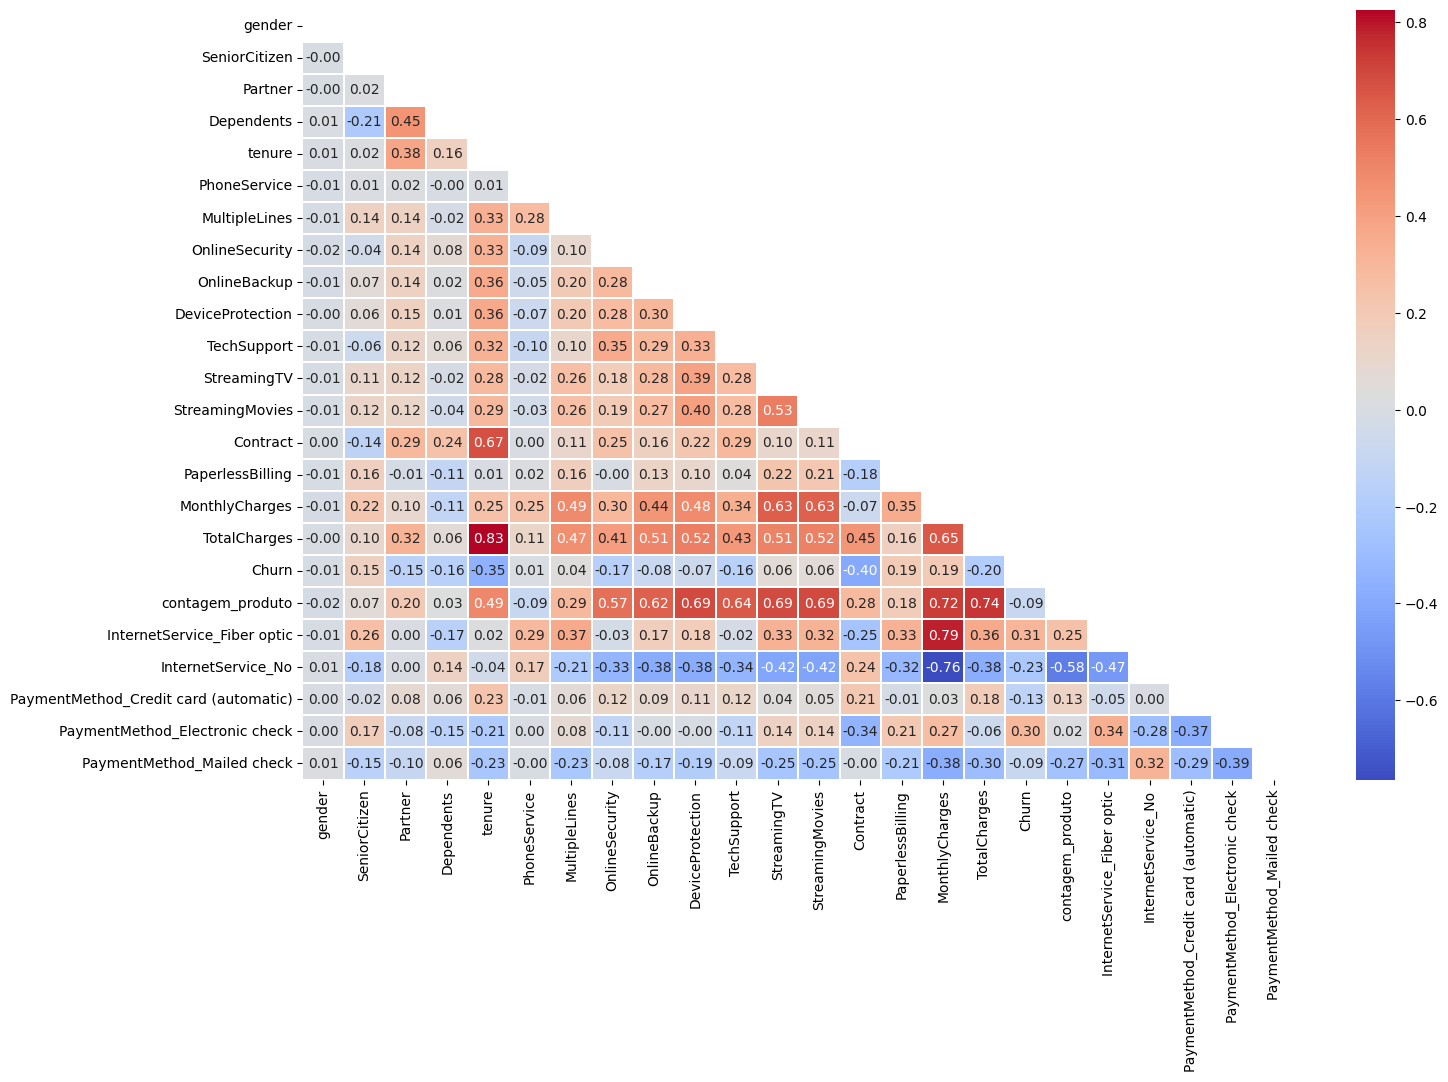

In [76]:
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,10))
ax = sns.heatmap(corr, mask=mask, fmt=".2f",xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm')
plt.show()

<Axes: >

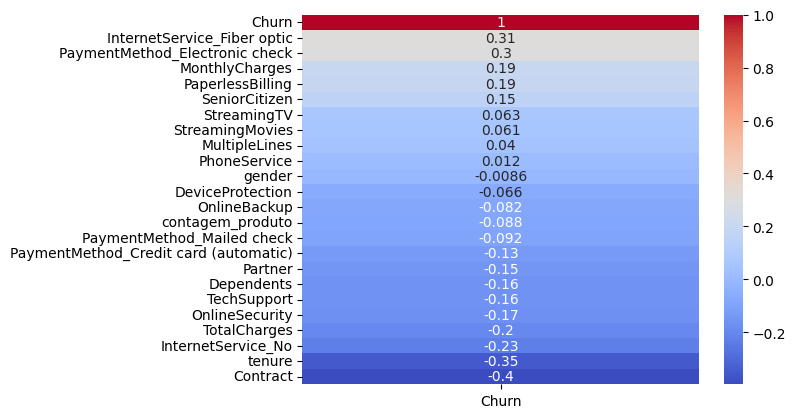

In [77]:
# Filtra apenas o que realmente importa para o Churn
top_corr = corr[['Churn']].sort_values(by='Churn', ascending=False)
sns.heatmap(top_corr, annot=True, cmap='coolwarm')

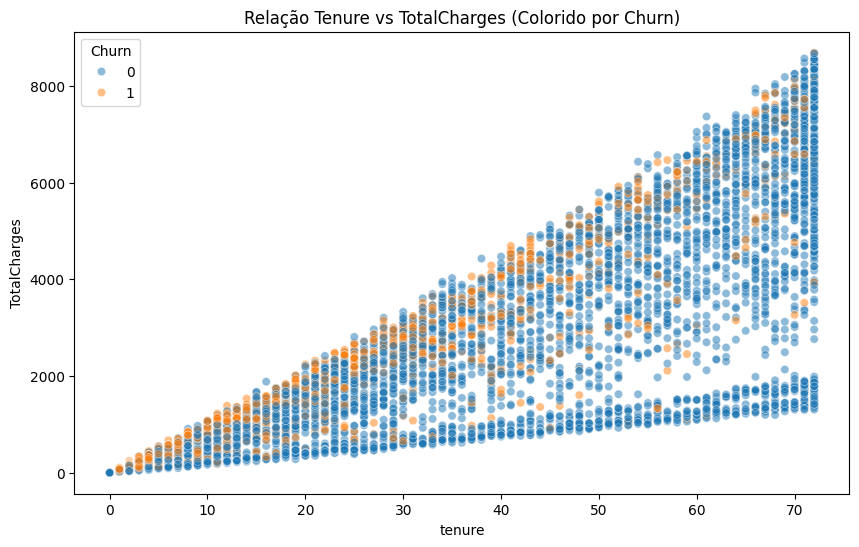

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='TotalCharges', hue='Churn', alpha=0.5)
plt.title('Relação Tenure vs TotalCharges (Colorido por Churn)')
plt.show()

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_vif(X):
    # O VIF precisa de uma constante (intercepto) para ser calculado corretamente
    # Mas para uma verificação rápida de colinearidade entre features, 
    # podemos usar o DataFrame original X.
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    
    # Calculando o VIF para cada coluna
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
    return vif_data.sort_values(by="VIF", ascending=False)

In [ ]:
X_vif = df.drop(columns=['Churn'])

vif_df = check_vif(X_vif)
print(vif_df)

                                  Feature         VIF
11                            StreamingTV         inf
7                          OnlineSecurity         inf
12                        StreamingMovies         inf
10                            TechSupport         inf
8                            OnlineBackup         inf
9                        DeviceProtection         inf
17                       contagem_produto         inf
15                         MonthlyCharges  211.163813
5                            PhoneService   47.099225
16                           TotalCharges   21.241867
4                                  tenure   20.266291
18            InternetService_Fiber optic   17.575982
19                     InternetService_No    8.193780
13                               Contract    4.216134
14                       PaperlessBilling    2.953602
21         PaymentMethod_Electronic check    2.952886
6                           MultipleLines    2.839950
2                           

In [81]:
df_limpo = df.drop(columns=['contagem_produto','MonthlyCharges', 'TotalCharges'])

In [102]:
vif_df = check_vif(X_vif)
print(vif_df)

                                  Feature       VIF
5                            PhoneService  9.224243
4                                  tenure  7.333105
13                               Contract  4.181082
15            InternetService_Fiber optic  3.574662
16                     InternetService_No  3.326144
2                                 Partner  2.819084
14                       PaperlessBilling  2.754516
12                        StreamingMovies  2.656259
11                            StreamingTV  2.634868
6                           MultipleLines  2.414499
18         PaymentMethod_Electronic check  2.400737
9                        DeviceProtection  2.239121
8                            OnlineBackup  2.091354
10                            TechSupport  2.061062
19             PaymentMethod_Mailed check  1.972184
3                              Dependents  1.962909
7                          OnlineSecurity  1.946648
0                                  gender  1.931344
17  PaymentM



## 🔴 FASE 4: Modeling (Modelagem)

* **Baseline:** Regressão Logística (O simples que funciona).
* **Otimização:** Teste com **Random Forest** ou **XGBoost** para capturar padrões complexos (ex: clientes que têm fibra mas não têm suporte técnico).
* **Validação:** Cross-Validation para garantir que o modelo não "viciou" nos dados de 2025.



In [83]:
# Como nossa target está desbalanceadas, vamos aplicar o SMOTE
def validacao_cruzada(modelo, X,y,oversampling=True):
    #iniciando nossa lista de acurácias
    acuracias = []

    # Separando os folds da validação cruzada
    kFold = KFold(n_splits=5)

    for indice,(indice_treino, indice_teste) in enumerate(kFold.split(X)):
        X_split_treino = X.iloc[indice_treino]
        y_split_treino = y.iloc[indice_treino]

        if oversampling:
            sm = SMOTE(random_state=42)

            X_split_treino, y_split_treino = sm.fit_resample(X_split_treino,y_split_treino)

            # Agora com os dados balanceados SÓ no treino, eu treino meu modelo

        # Validação sem os dados balanceados (oversampling)
        modelo.fit(X_split_treino, y_split_treino.values.flatten())

        X_split_teste = X.iloc[indice_teste]
        y_split_teste = y.iloc[indice_teste]

        predicoes_split = modelo.predict(X_split_teste)

        acuracia_split = accuracy_score(y_split_teste, predicoes_split)
        acuracias.append(acuracia_split)

        print(f'A acurácia do split {indice+1} foi {acuracia_split}')
        
    return acuracias



In [86]:
# Separando entre variáveis explicativas e resposta
X = df_limpo.drop(columns=['Churn'])
y = df.Churn


# Aplicar apenas nas numéricas para não estragar suas categorias do LightGBM
cols_num = ['tenure']

# 2. Instanciar e AJUSTAR apenas no treino
scaler = StandardScaler()
X_scaled = X.copy()

X_scaled[cols_num] = scaler.fit_transform(X_scaled[cols_num])


In [87]:
lr = LogisticRegression(random_state=42)
acc_lr = np.mean(validacao_cruzada(lr,X_scaled,y,oversampling=True))
acc_lr


A acurácia do split 1 foi 0.7494677075940384
A acurácia do split 2 foi 0.7665010645848119
A acurácia do split 3 foi 0.7359829666430092
A acurácia do split 4 foi 0.7464488636363636
A acurácia do split 5 foi 0.7514204545454546


np.float64(0.7499642114007355)

In [88]:
rf = RandomForestClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

acc_rf = np.mean(validacao_cruzada(rf,X,y,oversampling=True))
acc_lgb = np.mean(validacao_cruzada(lgb,X,y,oversampling=True))
acc_xgb = np.mean(validacao_cruzada(xgb,X,y,oversampling=True))


A acurácia do split 1 foi 0.7643718949609652
A acurácia do split 2 foi 0.7721788502484032
A acurácia do split 3 foi 0.7352732434350603
A acurácia do split 4 foi 0.7492897727272727
A acurácia do split 5 foi 0.7556818181818182
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
A acurácia do split 1 foi 0.765791341376863
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4129, number of negative: 4129
[Li

In [89]:
print(f'Regressão Logística: {acc_lr}')
print(f'Random Forest: {acc_rf}')
print(f'Light GBM: {acc_lgb}')
print(f'XGBoost: {acc_xgb}')

Regressão Logística: 0.7499642114007355
Random Forest: 0.7553591159107039
Light GBM: 0.7597606095554552
XGBoost: 0.7536559818375379


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

modelo_final = lgb

modelo_final.fit(X_train,y_train)

y_pred = modelo_final.predict(X_test)

acuracia_final = accuracy_score(y_test,y_pred)
acuracia_final

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418


0.7970191625266146



## 🟢 FASE 5: Evaluation (Avaliação de Resultados)


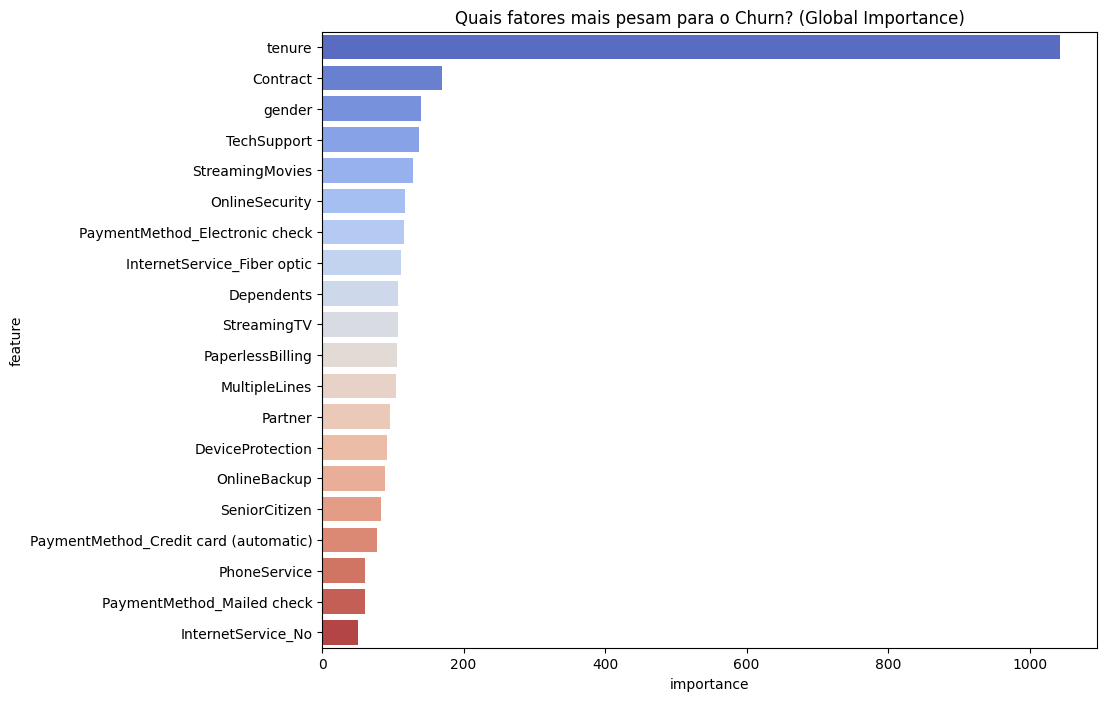

In [91]:
# Extraindo a importância do LightGBM
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': modelo_final.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importances, palette='coolwarm')
plt.title('Quais fatores mais pesam para o Churn? (Global Importance)')
plt.show()

In [92]:

print(classification_report(y_test, y_pred, target_names=['Fica', 'Churn']))

              precision    recall  f1-score   support

        Fica       0.84      0.89      0.87      1036
       Churn       0.64      0.54      0.58       373

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [93]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[923, 113],
       [173, 200]])

<Axes: >

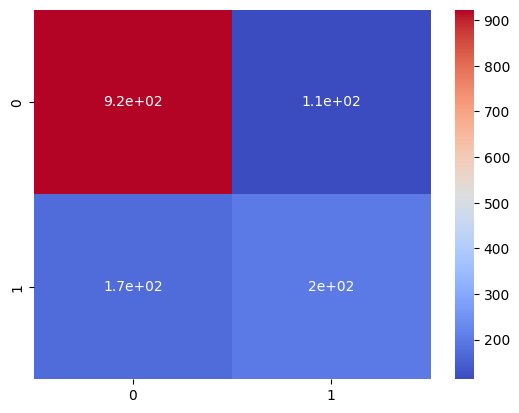

In [94]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='coolwarm')

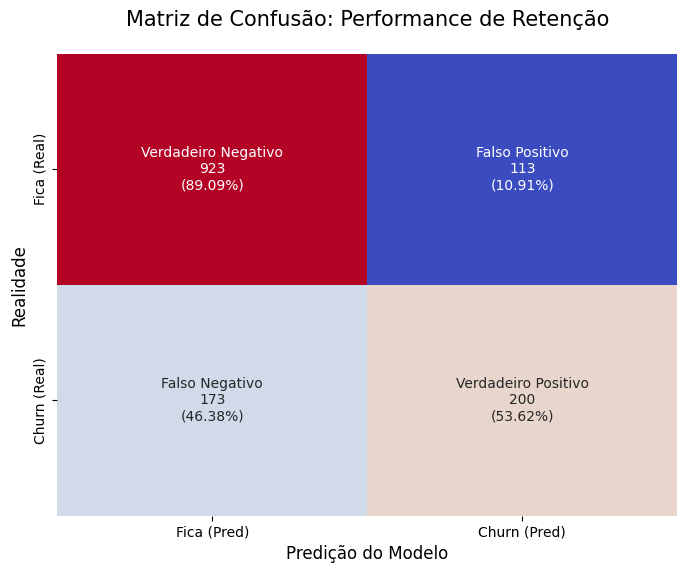

In [95]:

def plot_matriz_confusao_ajustada(y_real, y_pred):
    
    # Geramos a matriz bruta (contagens) e a matriz normalizada (proporções)
    cf_matrix = confusion_matrix(y_real, y_pred)
    cf_pct = confusion_matrix(y_real, y_pred, normalize='true')

    # Criamos os textos para cada célula: "Contagem \n (Porcentagem)"
    group_names = ['Verdadeiro Negativo', 'Falso Positivo', 'Falso Negativo', 'Verdadeiro Positivo']
    
    labels = [f"{name}\n{count}\n({pct:.2%})" for name, count, pct in 
              zip(group_names, cf_matrix.flatten(), cf_pct.flatten())]
    
    labels = np.asarray(labels).reshape(2,2)

    # Plotagem
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_pct, annot=labels, fmt='', cmap='coolwarm', cbar=False,
                xticklabels=['Fica (Pred)', 'Churn (Pred)'], 
                yticklabels=['Fica (Real)', 'Churn (Real)'])
    
    plt.title('Matriz de Confusão: Performance de Retenção', fontsize=15, pad=20)
    plt.ylabel('Realidade', fontsize=12)
    plt.xlabel('Predição do Modelo', fontsize=12)
    plt.show()

# Uso:
plot_matriz_confusao_ajustada(y_test, y_pred)

## Demonstração do resultado do modelo para o CFO

In [96]:
tn, fp, fn, tp = cf_matrix.ravel()
print(tn, fp, fn, tp )

# 2. Premissas de Negócio (Peça para o Roberto validar esses valores)
ticket_medio = df.MonthlyCharges.mean()     # Receita média mensal por cliente (MonthlyCharges médio)
custo_retencao = 20.00    # Custo da oferta (ex: desconto, bônus ou custo operacional)
taxa_sucesso = 0.40       # De 100 clientes que o modelo avisar, quantos conseguimos salvar?

# 3. Cálculos de Impacto
receita_preservada = (tp * ticket_medio) * taxa_sucesso
custo_campanha_total = (tp + fp) * custo_retencao
lucro_liquido = receita_preservada - custo_campanha_total
roi = (lucro_liquido / custo_campanha_total) * 100

# 4. Custo de Oportunidade (O que ainda estamos perdendo)
perda_invisivel = fn * ticket_medio

# --- RELATÓRIO PARA O CFO ---
print(f"=== SIMULAÇÃO DE IMPACTO FINANCEIRO (ConnectTel) ===")
print(f"Clientes Identificados para Retenção: {tp + fp}")
print(f"Receita Estimada Recuperada: R$ {receita_preservada:,.2f}")
print(f"Investimento na Campanha: R$ {custo_campanha_total:,.2f}")
print(f"---------------------------------------------------")
print(f"LUCRO LÍQUIDO ESTIMADO: R$ {lucro_liquido:,.2f}")
print(f"ROI DA OPERAÇÃO: {roi:.2f}%")
print(f"---------------------------------------------------")
print(f"Custo de Oportunidade (Clientes não detectados): R$ {perda_invisivel:,.2f}")

923 113 173 200
=== SIMULAÇÃO DE IMPACTO FINANCEIRO (ConnectTel) ===
Clientes Identificados para Retenção: 313
Receita Estimada Recuperada: R$ 5,180.94
Investimento na Campanha: R$ 6,260.00
---------------------------------------------------
LUCRO LÍQUIDO ESTIMADO: R$ -1,079.06
ROI DA OPERAÇÃO: -17.24%
---------------------------------------------------
Custo de Oportunidade (Clientes não detectados): R$ 11,203.77


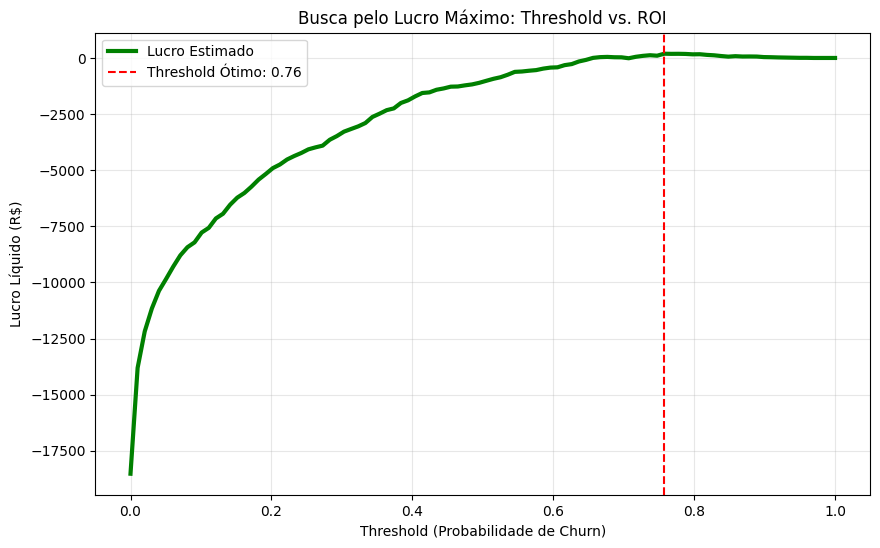

Melhor Threshold: 0.76
Lucro Máximo Estimado: R$ 188.76


In [97]:
def otimizar_threshold_lucro(modelo, X_teste, y_teste, ticket_medio, custo_retencao, taxa_sucesso):
    # 1. Pegamos as probabilidades em vez das classes
    y_probs = modelo.predict_proba(X_teste)[:, 1]
    
    thresholds = np.linspace(0, 1, 100)
    lucros = []

    for t in thresholds:
        y_pred_t = (y_probs > t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_teste, y_pred_t).ravel()
        
        # Lógica Financeira
        receita_salva = (tp * ticket_medio) * taxa_sucesso
        custo_total = (tp + fp) * custo_retencao
        lucro = receita_salva - custo_total
        lucros.append(lucro)

    # Encontrando o melhor ponto
    idx_max = np.argmax(lucros)
    best_t = thresholds[idx_max]
    best_lucro = lucros[idx_max]

    # Plotando a Curva de Lucro
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, lucros, color='green', lw=3, label='Lucro Estimado')
    plt.axvline(best_t, color='red', linestyle='--', label=f'Threshold Ótimo: {best_t:.2f}')
    plt.title('Busca pelo Lucro Máximo: Threshold vs. ROI')
    plt.xlabel('Threshold (Probabilidade de Churn)')
    plt.ylabel('Lucro Líquido (R$)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Melhor Threshold: {best_t:.2f}")
    print(f"Lucro Máximo Estimado: R$ {best_lucro:,.2f}")
    
    return best_t

# Executando a otimização
threshold_campeao = otimizar_threshold_lucro(
    modelo_final, X_test, y_test, 
    ticket_medio=ticket_medio, 
    custo_retencao=20.0, 
    taxa_sucesso=0.4
)

> - Roberto, percebemos que o custo da nossa campanha **(R$ 20)** é alto em relação ao nosso ticket médio. Se usarmos o modelo padrão (0.50), a operação dá prejuízo. No entanto, através desta simulação, descobri que se agirmos em clientes com probabilidade de Churn acima de 0.76, conseguimos maximizar a captura de receita e transformar o prejuízo de **17%** em um *lucro de **R$ 188.76**.

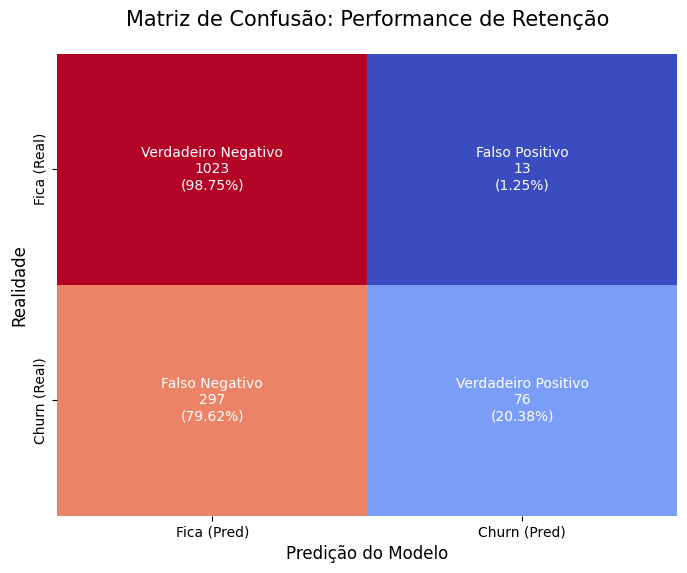

In [98]:
# Em vez de usar .predict(), usamos o threshold otimizado
y_prob_final = modelo_final.predict_proba(X_test)[:, 1]
y_pred_otimizado = (y_prob_final > threshold_campeao).astype(int)

plot_matriz_confusao_ajustada(y_test, y_pred_otimizado)

In [99]:
print(classification_report(y_test, y_pred_otimizado,target_names=['Fica', 'Churn']))

              precision    recall  f1-score   support

        Fica       0.78      0.99      0.87      1036
       Churn       0.85      0.20      0.33       373

    accuracy                           0.78      1409
   macro avg       0.81      0.60      0.60      1409
weighted avg       0.80      0.78      0.73      1409



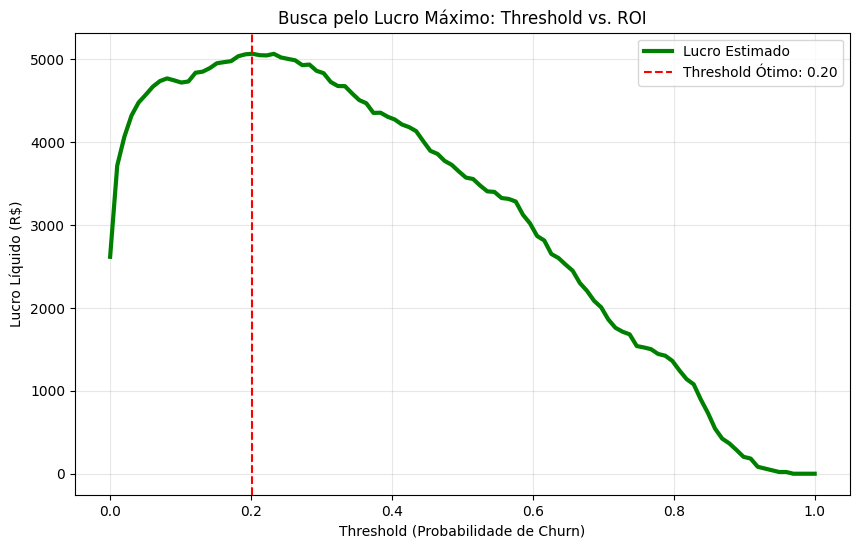

Melhor Threshold: 0.20
Lucro Máximo Estimado: R$ 5,068.12


In [100]:
# E se conseguissemos deixar a campanha mais barata?
threshold_campeao = otimizar_threshold_lucro(
    modelo_final, X_test, y_test, 
    ticket_medio=ticket_medio, 
    custo_retencao=5.0, 
    taxa_sucesso=0.4
)

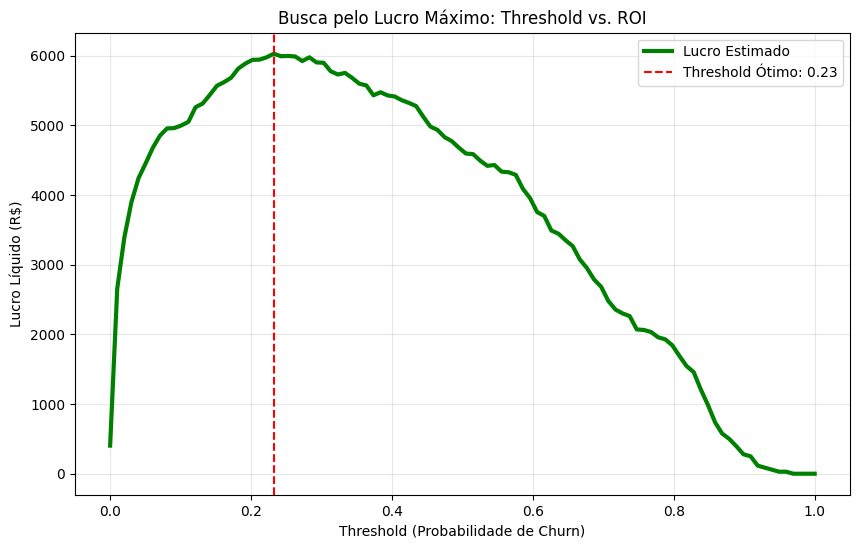

Melhor Threshold: 0.23
Lucro Máximo Estimado: R$ 6,027.67


In [101]:
# E se conseguirmos aumentar nossa taxa de conversão?
threshold_campeao = otimizar_threshold_lucro(
    modelo_final, X_test, y_test, 
    ticket_medio=ticket_medio, 
    custo_retencao=10.0, 
    taxa_sucesso=0.6
)




## 🟣 FASE 6: Deployment (Entrada em Produção)

* **Artefatos:** Salvando o modelo com `joblib`.
* **Monitoramento:** Definir o check de "Data Drift" (se a concorrência lançar um plano novo, o comportamento do cliente muda e o modelo precisa de retreino).




In [ ]:
import joblib

joblib.dump(modelo_final,'modelo_final.joblib')